# Experiments on synthetic data

Code to obtain the results in Section 4 of NeurIPS 2021 Paper6977 submission,
for the proposed Conformal RNN model. This also briefly reviews the code to run the
BJRNN baseline.

In [363]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Required imports

In [321]:
import numpy as np
import pickle
import torch

from matplotlib import pyplot as plt
%matplotlib inline

In [364]:
from utils.data_processing_synthetic import generate_raw_sequences

In [368]:
raw_seq = generate_raw_sequences(experiment='dynamic-lengths', seed=0, cached=False)

hi
hi


In [370]:
(X_train, Y_train, l), (X_test, Y_test, ll) = raw_seq[0]

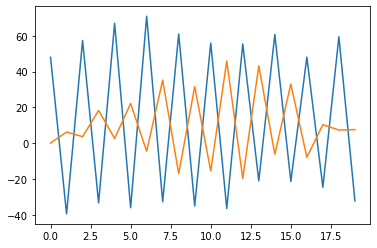

In [374]:
plt.plot(X_train[0].numpy())
plt.plot(X_train[256].numpy())

In [375]:
(X_train, Y_train, l), (X_test, Y_test, ll) = raw_seq[1]

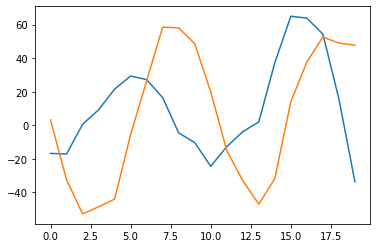

In [376]:
plt.plot(X_train[0].numpy())
plt.plot(X_train[256].numpy())

In [276]:
results_qrnn = run_synthetic_experiments(params=None, baselines=['QRNN'], retrain=True,
                              generate_datasets=False,
                              experiment='time-dependent',
                              correct_conformal=True, save_model=False,
                              save_results=True, rnn_mode='RNN', seed=0)

Training QRNN
Training dataset 0
Epoch:  0 | train loss: 0.6736
Epoch:  1 | train loss: 0.6871
Epoch:  2 | train loss: 0.6839
Epoch:  3 | train loss: 0.6070
Epoch:  4 | train loss: 0.6698
Epoch:  5 | train loss: 0.6499
Epoch:  6 | train loss: 0.6393
Epoch:  7 | train loss: 0.5880
Epoch:  8 | train loss: 0.6533
Epoch:  9 | train loss: 0.6061
Training dataset 1
Epoch:  0 | train loss: 0.7626
Epoch:  1 | train loss: 0.8442
Epoch:  2 | train loss: 0.8417
Epoch:  3 | train loss: 0.9462
Epoch:  4 | train loss: 0.7959
Epoch:  5 | train loss: 0.8056
Epoch:  6 | train loss: 0.7959
Epoch:  7 | train loss: 0.8005
Epoch:  8 | train loss: 0.7632
Epoch:  9 | train loss: 0.8072
Training dataset 2
Epoch:  0 | train loss: 1.0116
Epoch:  1 | train loss: 0.9885
Epoch:  2 | train loss: 0.9941
Epoch:  3 | train loss: 0.9656
Epoch:  4 | train loss: 0.9650
Epoch:  5 | train loss: 0.9563
Epoch:  6 | train loss: 0.9144
Epoch:  7 | train loss: 0.9493
Epoch:  8 | train loss: 0.9085
Epoch:  9 | train loss: 1.0193

In [332]:
with open('saved_results/time-dependent_QRNN_0.pkl', 'rb') as f:
    qrnn_seed_results = pickle.load(f)

In [333]:
for seed_res in qrnn_seed_results:
    print(seed_res['Mean confidence interval widths'], seed_res['Mean joint coverage'])

[ 7.6717014  9.938807  10.802449  11.936611  12.502933 ] 0.656
[ 9.524176 11.48077  12.755836 13.951571 14.974193] 0.594
[12.170261 14.901433 16.342573 17.23948  17.884007] 0.584
[15.725971 18.323359 19.509663 21.214985 22.487434] 0.582
[18.688084 20.98777  22.166533 24.904823 27.376888] 0.578


In [316]:
for i, raw_sequence_dataset in enumerate(dataset1):
    train_dataset, calibration_dataset, test_dataset = \
                        get_synthetic_dataset(raw_sequence_dataset,
                                              conformal=True, seed=0)
    print(len(train_dataset))
    break

1000


In [279]:
results_dprnn = run_synthetic_experiments(params=None, baselines=['DPRNN'], retrain=True,
                              generate_datasets=False,
                              experiment='time-dependent',
                              correct_conformal=True, save_model=False,
                              save_results=True, rnn_mode='RNN', seed=0)

Training DPRNN
Training dataset 0
Epoch:  0 | train loss: 11.2059
Epoch:  1 | train loss: 13.5496
Epoch:  2 | train loss: 11.1306
Epoch:  3 | train loss: 13.3762
Epoch:  4 | train loss: 10.8653
Epoch:  5 | train loss: 11.4850
Epoch:  6 | train loss: 10.4239
Epoch:  7 | train loss: 11.2724
Epoch:  8 | train loss: 9.3682
Epoch:  9 | train loss: 10.3301
Training dataset 1
Epoch:  0 | train loss: 20.4983
Epoch:  1 | train loss: 18.2219
Epoch:  2 | train loss: 15.7987
Epoch:  3 | train loss: 18.3304
Epoch:  4 | train loss: 16.9499
Epoch:  5 | train loss: 14.8345
Epoch:  6 | train loss: 17.3644
Epoch:  7 | train loss: 17.0669
Epoch:  8 | train loss: 13.6837
Epoch:  9 | train loss: 12.9853
Training dataset 2
Epoch:  0 | train loss: 25.9788
Epoch:  1 | train loss: 28.7743
Epoch:  2 | train loss: 25.1717
Epoch:  3 | train loss: 26.4531
Epoch:  4 | train loss: 27.1879
Epoch:  5 | train loss: 23.4812
Epoch:  6 | train loss: 24.7267
Epoch:  7 | train loss: 24.2386
Epoch:  8 | train loss: 21.2951
E

In [269]:
results = run_synthetic_experiments(params=None, baselines=['QRNN', 'DPRNN'], retrain=True,
                              generate_datasets=False,
                              experiment='time-dependent',
                              correct_conformal=True, save_model=False,
                              save_results=True, rnn_mode='RNN', seed=0)

Training QRNN
Training dataset 0
Epoch:  0 | train loss: 0.6866
Epoch:  1 | train loss: 0.6700
Epoch:  2 | train loss: 0.6769
Epoch:  3 | train loss: 0.6681
Epoch:  4 | train loss: 0.6366
Epoch:  5 | train loss: 0.6517
Epoch:  6 | train loss: 0.6032
Epoch:  7 | train loss: 0.6011
Epoch:  8 | train loss: 0.5875
Epoch:  9 | train loss: 0.5943
Example 0
Example 50
Example 100
Example 150
Example 200
Example 250
Example 300
Example 350
Example 400
Example 450
Training dataset 1
Epoch:  0 | train loss: 0.7666
Epoch:  1 | train loss: 0.8529
Epoch:  2 | train loss: 0.8841
Epoch:  3 | train loss: 0.8776
Epoch:  4 | train loss: 0.8041
Epoch:  5 | train loss: 0.7746
Epoch:  6 | train loss: 0.8050
Epoch:  7 | train loss: 0.7724
Epoch:  8 | train loss: 0.8092
Epoch:  9 | train loss: 0.7488
Example 0
Example 50
Example 100
Example 150
Example 200
Example 250
Example 300
Example 350
Example 400
Example 450
Training dataset 2
Epoch:  0 | train loss: 1.0197
Epoch:  1 | train loss: 0.9993
Epoch:  2 | t

In [336]:
with open('saved_results/all_time_dependent_results.pkl', 'rb') as f:
    all_time_dependent_results = pickle.load(f)

In [341]:
for baseline in ['CPRNN', 'CPRNN-normalised', 'QRNN', 'DPRNN']:
    print(baseline)
    coverages = []
    for all_baselines_for_seed in all_time_dependent_results:
        c = []
        for result in all_baselines_for_seed[baseline]:
            c.append(result['Mean joint coverage'] * 100)
        coverages.append(c)
    coverages = np.array(coverages)
    for m, s in zip(coverages.mean(axis=0), coverages.std(axis=0)):
        print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))
    print()

CPRNN
92.9 \(\pm\) 0.7\%
91.5 \(\pm\) 1.1\%
90.8 \(\pm\) 2.2\%
91.1 \(\pm\) 1.8\%
89.4 \(\pm\) 0.9\%

CPRNN-normalised
92.9 \(\pm\) 1.6\%
92.0 \(\pm\) 1.8\%
90.9 \(\pm\) 1.4\%
91.4 \(\pm\) 1.9\%
90.6 \(\pm\) 0.5\%

QRNN
61.7 \(\pm\) 3.9\%
58.0 \(\pm\) 2.1\%
59.4 \(\pm\) 3.1\%
57.9 \(\pm\) 1.7\%
57.2 \(\pm\) 1.5\%

DPRNN
3.6 \(\pm\) 0.5\%
1.5 \(\pm\) 0.5\%
0.4 \(\pm\) 0.2\%
0.3 \(\pm\) 0.2\%
0.2 \(\pm\) 0.3\%



In [350]:
for baseline in ['CPRNN', 'CPRNN-normalised', 'QRNN', 'DPRNN']:
    print(baseline)
    coverages = []
    for all_baselines_for_seed in all_time_dependent_results:
        c = []
        for result in all_baselines_for_seed[baseline]:
            independent_coverages = result['Mean independent coverage']
            print(independent_coverages)
            print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
            break # for a single seed
    print()

CPRNN
tensor([0.9760, 0.9760, 0.9800, 0.9920, 0.9740])
[97.4\%, 99.2\%]
tensor([0.9720, 0.9740, 0.9700, 0.9720, 0.9720])
[97.0\%, 97.4\%]
tensor([0.9760, 0.9700, 0.9860, 0.9860, 0.9780])
[97.0\%, 98.6\%]
tensor([0.9880, 0.9760, 0.9880, 0.9700, 0.9680])
[96.8\%, 98.8\%]
tensor([0.9860, 0.9740, 0.9760, 0.9760, 0.9860])
[97.4\%, 98.6\%]

CPRNN-normalised
tensor([0.9760, 0.9840, 0.9760, 0.9840, 0.9800])
[97.6\%, 98.4\%]
tensor([0.9780, 0.9780, 0.9640, 0.9840, 0.9820])
[96.4\%, 98.4\%]
tensor([0.9820, 0.9620, 0.9740, 0.9740, 0.9760])
[96.2\%, 98.2\%]
tensor([0.9900, 0.9800, 0.9800, 0.9820, 0.9760])
[97.6\%, 99.0\%]
tensor([0.9820, 0.9700, 0.9860, 0.9720, 0.9760])
[97.0\%, 98.6\%]

QRNN
[0.896 0.898 0.874 0.88  0.87 ]
[87.0\%, 89.8\%]
[0.89  0.882 0.87  0.888 0.866]
[86.6\%, 89.0\%]
[0.854 0.832 0.838 0.826 0.846]
[82.6\%, 85.4\%]
[0.852 0.858 0.842 0.83  0.84 ]
[83.0\%, 85.8\%]
[0.894 0.858 0.888 0.876 0.868]
[85.8\%, 89.4\%]

DPRNN
[0.466 0.378 0.316 0.322 0.254]
[25.4\%, 46.6\%]
[0.458 0.

In [348]:
for baseline in ['CPRNN', 'CPRNN-normalised', 'QRNN', 'DPRNN']:
    print(baseline)
    wws = []
    for all_baselines_for_seed in all_time_dependent_results:
        ws = []
        for result in all_baselines_for_seed[baseline]:
            widths = result['Mean confidence interval widths']
            ws.append('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
        wws.append(ws)
#         break # for a single seed
    
    for i in range(5):
        print('{} & {} & {} & {} & {}'.format(wws[0][i], wws[1][i], wws[2][i], wws[3][i], wws[4][i]))
    print()

CPRNN
19.08 \(\pm\) 4.06 & 18.17 \(\pm\) 3.54 & 19.60 \(\pm\) 4.26 & 19.10 \(\pm\) 4.04 & 20.23 \(\pm\) 4.35
22.58 \(\pm\) 4.45 & 22.65 \(\pm\) 4.46 & 23.38 \(\pm\) 4.32 & 22.92 \(\pm\) 4.09 & 21.97 \(\pm\) 5.04
27.15 \(\pm\) 4.58 & 27.51 \(\pm\) 4.88 & 26.14 \(\pm\) 5.07 & 26.93 \(\pm\) 4.85 & 26.97 \(\pm\) 4.66
32.50 \(\pm\) 5.63 & 33.35 \(\pm\) 5.88 & 33.67 \(\pm\) 6.20 & 35.10 \(\pm\) 6.63 & 33.72 \(\pm\) 5.50
39.17 \(\pm\) 7.72 & 38.51 \(\pm\) 6.05 & 39.52 \(\pm\) 8.43 & 37.68 \(\pm\) 6.85 & 39.13 \(\pm\) 5.98

CPRNN-normalised
21.84 \(\pm\) 5.23 & 21.70 \(\pm\) 5.19 & 21.02 \(\pm\) 4.83 & 21.10 \(\pm\) 5.04 & 21.71 \(\pm\) 5.41
24.73 \(\pm\) 5.35 & 24.78 \(\pm\) 5.60 & 27.52 \(\pm\) 6.53 & 25.40 \(\pm\) 5.37 & 23.35 \(\pm\) 5.15
29.83 \(\pm\) 5.97 & 29.74 \(\pm\) 6.51 & 27.67 \(\pm\) 6.04 & 29.35 \(\pm\) 5.32 & 29.49 \(\pm\) 5.72
33.94 \(\pm\) 6.71 & 36.16 \(\pm\) 5.95 & 36.85 \(\pm\) 7.14 & 39.00 \(\pm\) 9.17 & 38.00 \(\pm\) 6.85
44.14 \(\pm\) 10.98 & 43.37 \(\pm\) 8.77 & 45.45 

In [256]:
for baseline in results.keys():
    print(baseline)
    for i in range(len(results[baseline])):
        print(results[baseline][i]['Mean confidence interval widths'], results[baseline][i]['Mean joint coverage'])
    print()

CPRNN
tensor([12.9511, 15.3495, 18.5207, 21.5026, 22.7859], grad_fn=<MeanBackward1>) 0.9200000166893005
tensor([16.7277, 18.5400, 19.6937, 20.8678, 21.6073], grad_fn=<MeanBackward1>) 0.9039999842643738
tensor([19.8832, 23.7368, 23.5400, 27.2586, 28.9963], grad_fn=<MeanBackward1>) 0.9079999923706055
tensor([22.9493, 24.5373, 28.4677, 30.3819, 33.4077], grad_fn=<MeanBackward1>) 0.8999999761581421
tensor([26.4023, 31.4824, 32.5492, 35.9741, 39.4215], grad_fn=<MeanBackward1>) 0.9100000262260437

CPRNN-normalised
tensor([12.7866, 15.0968, 18.5979, 20.9320, 23.0319], grad_fn=<MeanBackward1>) 0.8920000195503235
tensor([16.4482, 18.5707, 20.0904, 21.4002, 22.2892], grad_fn=<MeanBackward1>) 0.9079999923706055
tensor([19.9742, 24.3301, 24.1771, 27.2557, 29.7749], grad_fn=<MeanBackward1>) 0.9200000166893005
tensor([22.7421, 24.3797, 29.0538, 30.4655, 34.1906], grad_fn=<MeanBackward1>) 0.8960000276565552
tensor([26.7563, 32.8340, 32.6192, 34.7802, 40.4933], grad_fn=<MeanBackward1>) 0.9219999909400

In [272]:
for baseline in results.keys():
    print(baseline)
    for i in range(len(results[baseline])):
        print(results[baseline][i]['interval_widths'], results[baseline][i]['mean_coverage'])
    print()

CPRNN

CPRNN-normalised

BJRNN

QRNN
[[ 7.5249033]
 [ 9.43994  ]
 [11.226031 ]
 [13.487157 ]
 [14.962022 ]] 0.4064
[[10.080579]
 [11.42857 ]
 [12.815769]
 [12.488897]
 [15.765036]] 0.672
[[13.824842]
 [15.762233]
 [17.800226]
 [20.10096 ]
 [20.232811]] 0.7608
[[14.793912]
 [16.197235]
 [19.38772 ]
 [20.641893]
 [19.125643]] 0.7052
[[18.902   ]
 [22.660154]
 [23.333727]
 [23.809486]
 [26.395449]] 0.7956

DPRNN
[[7.6389017]
 [7.1191316]
 [7.086136 ]
 [7.0100965]
 [6.446491 ]] 0.25
[[1.4255496 ]
 [1.0067878 ]
 [0.8377309 ]
 [0.74006915]
 [0.6891741 ]] 0.0
[[3.848425 ]
 [3.5828753]
 [3.584048 ]
 [3.5035236]
 [3.0751982]] 0.2084
[[3.5424511]
 [3.602528 ]
 [3.2469482]
 [3.9407895]
 [3.5507135]] 0.1032
[[6.1087713]
 [6.2613196]
 [6.827024 ]
 [6.7695246]
 [7.94724  ]] 0.2036



In [313]:
for ds1, ds2 in zip(dataset1, dataset2):
    for i, j in zip(ds1[0][0], ds2[0][0]):
        assert torch.allclose(i, j)

In [310]:
len(ds1[0][0])

2000

In [277]:
for baseline in results.keys():
    print(baseline)
    for i in range(len(results_qrnn[baseline])):
        print(results_qrnn[baseline][i]['Mean confidence interval widths'], results_qrnn[baseline][i]['Mean joint coverage'])
    print()

CPRNN

CPRNN-normalised

BJRNN

QRNN
[ 7.72704   9.357125 10.990964 11.934395 12.500709] 0.63
[10.227398  11.35734   12.573654  13.402909  15.2695055] 0.574
[12.696457 14.474907 16.353626 17.807388 18.785158] 0.58
[15.826129 17.153152 19.079737 21.4164   22.057575] 0.562
[18.285498 20.992868 22.809141 23.970427 25.856745] 0.62

DPRNN



In [280]:
for baseline in results.keys():
    print(baseline)
    for i in range(len(results_dprnn[baseline])):
        print(results_dprnn[baseline][i]['Mean confidence interval widths'], results_dprnn[baseline][i]['Mean joint coverage'])
    print()

CPRNN

CPRNN-normalised

BJRNN

QRNN

DPRNN
[3.7458959 3.4510856 3.3635511 3.242023  2.9528723] 0.038
[3.4916246 3.1744852 2.9266303 2.7746978 2.64875  ] 0.006
[3.8773158 3.7548902 3.697274  3.751678  3.559165 ] 0.008
[3.7084422 3.3833694 3.4921312 3.3912055 3.3155577] 0.004
[3.7737503 3.7983296 3.838728  3.510264  4.1043124] 0.002



In [250]:
results['CPRNN'][0]['Point predictions']

tensor([[[ 6.1158],
         [ 7.2552],
         [ 7.2383],
         [ 7.0832],
         [ 8.2965]],

        [[ 6.0883],
         [ 7.0689],
         [ 6.7759],
         [ 6.5124],
         [ 7.6677]],

        [[ 9.3525],
         [10.2137],
         [10.7093],
         [10.8073],
         [11.6597]],

        ...,

        [[ 3.3704],
         [ 4.5560],
         [ 4.3383],
         [ 4.6860],
         [ 6.0410]],

        [[ 3.7637],
         [ 4.4065],
         [ 4.5491],
         [ 4.8839],
         [ 5.7806]],

        [[ 1.0628],
         [ 1.8155],
         [ 2.0628],
         [ 2.2048],
         [ 3.0477]]], grad_fn=<CatBackward>)

In [245]:
print(results.keys())

dict_keys(['CPRNN', 'CPRNN-normalised', 'BJRNN', 'QRNN', 'DPRNN'])


In [10]:
datasets = get_synthetic_splits(noise_mode='static', cached=False)

In [11]:
datasets

[(<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bfa387d0>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bd408e10>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bfae8690>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0b9a57dd0>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bfaabcd0>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bfaab910>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0beaafe10>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bf9cbf50>),
 (<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0bbe56510>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd0b9aab410>)]

In [119]:
results = []

In [227]:
input_size=1
embedding_size=20
coverage=0.9
epochs=1000
lr=0.01
batch_size=32
rnn_mode='LSTM'
experiment_mode='static'

results=[]
normalised_results=[]

for i, dataset in enumerate(datasets):
    if experiment_mode == 'long-horizon':
        horizon = EXPERIMENT_MODES[experiment_mode][i]
    else:
        horizon = HORIZONS[experiment_mode]

    train_dataset, calibration_dataset, test_dataset = dataset

    model = CoRNN(embedding_size=embedding_size, horizon=horizon,error_rate=1 - coverage, mode=rnn_mode)
    model.fit(train_dataset, calibration_dataset, epochs=epochs, lr=lr,
              batch_size=batch_size)


    result = evaluate_cornn_performance(model, test_dataset, normalised=False)
    results.append(result)

    normalised_result = evaluate_cornn_performance(model, test_dataset, normalised=True)
    normalised_results.append(normalised_result)

Epoch: 0	Train loss: 41.13853347301483
Epoch: 50	Train loss: 8.785969078540802
Epoch: 100	Train loss: 7.302737772464752
Epoch: 150	Train loss: 5.847483649849892
Epoch: 200	Train loss: 5.461999289691448
Epoch: 250	Train loss: 4.667337715625763
Epoch: 300	Train loss: 5.211041137576103
Epoch: 350	Train loss: 4.0589210614562035
Epoch: 400	Train loss: 3.700950913131237
Epoch: 450	Train loss: 3.554953597486019
Epoch: 500	Train loss: 3.3208678141236305
Epoch: 550	Train loss: 5.675628140568733
Epoch: 600	Train loss: 3.318308435380459
Epoch: 650	Train loss: 5.0843754559755325
Epoch: 700	Train loss: 3.9424339905381203
Epoch: 750	Train loss: 3.2784859389066696
Epoch: 800	Train loss: 3.614255338907242
Epoch: 850	Train loss: 3.172774203121662
Epoch: 900	Train loss: 5.170785337686539
Epoch: 950	Train loss: 2.912680871784687
Epoch: 0	Normalisation loss: 1.4207360930740833
Epoch: 0	Train loss: 47.674999356269836
Epoch: 50	Train loss: 8.575003504753113
Epoch: 100	Train loss: 6.931078642606735
Epoch: 15

In [224]:
results[0].keys()

dict_keys(['Point predictions', 'Errors', 'Independent coverage indicators', 'Joint coverage indicators', 'Upper limit', 'Lower limit', 'Mean independent coverage', 'Mean joint coverage', 'Confidence interval widths', 'Mean confidence interval widths'])

beta = 10

In [228]:
for i in range(len(datasets)):
    print(results[i]['Mean confidence interval widths'])
    print(normalised_results[i]['Mean confidence interval widths'])
    print()
# print(results[1]['Mean confidence interval widths'])

tensor([11.8933, 16.0001, 18.0092, 19.4610, 20.1420], grad_fn=<MeanBackward1>)
tensor([11.8977, 16.1370, 18.1335, 19.4793, 20.3947], grad_fn=<MeanBackward1>)

tensor([11.8004, 16.0806, 18.3719, 19.0989, 19.8601], grad_fn=<MeanBackward1>)
tensor([11.8505, 15.9837, 18.1783, 19.3589, 19.9890], grad_fn=<MeanBackward1>)

tensor([12.1827, 15.7478, 18.2316, 19.8605, 23.3259], grad_fn=<MeanBackward1>)
tensor([12.1382, 15.8411, 18.2825, 19.5191, 23.4165], grad_fn=<MeanBackward1>)

tensor([11.2390, 14.9808, 17.7509, 19.7164, 21.5000], grad_fn=<MeanBackward1>)
tensor([11.3804, 15.0361, 17.7476, 19.7371, 21.5955], grad_fn=<MeanBackward1>)

tensor([11.9142, 15.6461, 19.2478, 21.3445, 22.1178], grad_fn=<MeanBackward1>)
tensor([11.6942, 15.8416, 19.1317, 21.5692, 22.1283], grad_fn=<MeanBackward1>)



beta = 5

In [225]:
for i in range(len(datasets)):
    print(results[i]['Mean confidence interval widths'])
    print(normalised_results[i]['Mean confidence interval widths'])
    print()
# print(results[1]['Mean confidence interval widths'])

tensor([11.4452, 15.5842, 17.9923, 19.1451, 21.9740], grad_fn=<MeanBackward1>)
tensor([11.4144, 15.5037, 18.0730, 19.3088, 21.5220], grad_fn=<MeanBackward1>)

tensor([12.6807, 16.7591, 19.8282, 22.5709, 23.6736], grad_fn=<MeanBackward1>)
tensor([12.6937, 16.9692, 20.4929, 22.2832, 22.8056], grad_fn=<MeanBackward1>)

tensor([11.3268, 14.7228, 17.6204, 19.1182, 21.5176], grad_fn=<MeanBackward1>)
tensor([11.2684, 14.7711, 17.6920, 19.1326, 21.7591], grad_fn=<MeanBackward1>)

tensor([11.2458, 14.8314, 16.7045, 18.4192, 20.3285], grad_fn=<MeanBackward1>)
tensor([11.3188, 15.0354, 16.9378, 18.4587, 20.5030], grad_fn=<MeanBackward1>)

tensor([11.5727, 15.1697, 18.6059, 20.8479, 22.1037], grad_fn=<MeanBackward1>)
tensor([11.6164, 14.9272, 18.5793, 20.9912, 22.4142], grad_fn=<MeanBackward1>)



beta <= 1

In [215]:
for i in range(len(datasets)):
    print(results[i]['Mean confidence interval widths'])
    print(normalised_results[i]['Mean confidence interval widths'])
    print()
# print(results[1]['Mean confidence interval widths'])

tensor([11.1046, 14.6474, 17.7534, 20.6654, 22.2522], grad_fn=<MeanBackward1>)
tensor([11.6641, 15.5433, 18.9478, 22.3507, 26.7966], grad_fn=<MeanBackward1>)

tensor([12.0450, 15.0401, 18.4608, 20.0643, 19.3256], grad_fn=<MeanBackward1>)
tensor([12.4043, 17.1748, 20.9464, 21.2146, 22.2224], grad_fn=<MeanBackward1>)

tensor([11.7879, 15.4926, 18.6746, 20.2470, 22.1670], grad_fn=<MeanBackward1>)
tensor([12.8238, 16.8156, 21.1878, 22.1664, 25.2456], grad_fn=<MeanBackward1>)

tensor([11.1238, 15.4579, 16.4373, 19.8149, 20.6064], grad_fn=<MeanBackward1>)
tensor([11.1300, 16.3174, 18.8205, 21.6866, 21.6510], grad_fn=<MeanBackward1>)

tensor([11.2460, 14.2197, 18.5439, 20.1186, 21.0079], grad_fn=<MeanBackward1>)
tensor([11.9492, 14.3833, 19.3308, 21.8882, 21.3039], grad_fn=<MeanBackward1>)



In [233]:
for i in range(len(datasets)):
    print(results[i]['Mean joint coverage'])
    print(normalised_results[i]['Mean joint coverage'])
    print()
# print(results[1]['Mean joint coverage'])

0.9259999990463257
0.9300000071525574

0.9240000247955322
0.921999990940094

0.9520000219345093
0.9440000057220459

0.9100000262260437
0.9160000085830688

0.9399999976158142
0.9359999895095825



In [234]:
for i in range(len(datasets)):
    print(results[i]['Mean independent coverage'])
    print(normalised_results[i]['Mean independent coverage'])
    print()
# print(results[1]['Mean independent coverage'])

tensor([0.9760, 0.9840, 0.9680, 0.9780, 0.9780])
tensor([0.9760, 0.9840, 0.9700, 0.9780, 0.9800])

tensor([0.9780, 0.9800, 0.9760, 0.9620, 0.9540])
tensor([0.9780, 0.9760, 0.9760, 0.9640, 0.9540])

tensor([0.9860, 0.9900, 0.9880, 0.9720, 0.9920])
tensor([0.9820, 0.9940, 0.9840, 0.9680, 0.9920])

tensor([0.9720, 0.9720, 0.9740, 0.9680, 0.9780])
tensor([0.9740, 0.9740, 0.9760, 0.9700, 0.9760])

tensor([0.9820, 0.9740, 0.9880, 0.9880, 0.9840])
tensor([0.9820, 0.9740, 0.9840, 0.9880, 0.9800])



In [231]:
model.corrected_critical_calibration_scores

tensor([[ 5.9571],
        [ 7.8230],
        [ 9.6239],
        [10.6723],
        [11.0589]])

In [232]:
model.normalised_corrected_critical_calibration_scores

tensor([[0.5269],
        [0.6971],
        [0.8393],
        [0.9350],
        [0.9550]])

In [125]:
print(results[0]['Mean confidence interval widths'])
print(results[1]['Mean confidence interval widths'])

tensor([11.5653, 16.9678, 21.2433, 23.5103, 23.4713], grad_fn=<MeanBackward1>)
tensor([11.2240, 15.1474, 18.4298, 19.8885, 20.9379], grad_fn=<MeanBackward1>)


In [126]:
print(results[0]['Mean joint coverage'])
print(results[1]['Mean joint coverage'])

0.9419999718666077
0.9380000233650208


In [127]:
print(results[0]['Mean independent coverage'])
print(results[1]['Mean independent coverage'])

tensor([0.9700, 0.9900, 0.9840, 0.9860, 0.9860])
tensor([0.9700, 0.9780, 0.9860, 0.9820, 0.9800])


## Time-dependent noise profile (Figure 3, Table 2)

Dataset generation process:

```python
# Generate a new dataset
all_time_dependent_results = []
for i in range(5):
    get_synthetic_splits(noise_mode='time-dependent', cached=False)
    time_dependent_results = train_conformal_forecaster(noise_mode='time-dependent', retrain=True)
    all_time_dependent_results.append(time_dependent_results)
    
with open('saved_results/all_time_dependent_results.pkl', 'wb') as f:
    pickle.dump(all_time_dependent_results, f, protocol=pickle.HIGHEST_PROTOCOL)
```

Loading saved results:

In [ ]:
with open('saved_results/all_time_dependent_results.pkl', 'wb') as f:
    all_time_dependent_results = pickle.load(f)

Evaluation:

**Joint coverage**

In [20]:
coverages = []
for time_dependent_results in all_time_dependent_results:
    c = []
    for result in time_dependent_results:
        c.append(result['Mean joint coverage'] * 100)
    coverages.append(c)
coverages = np.array(coverages)
for m, s in zip(coverages.mean(axis=0), coverages.std(axis=0)):
    print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))

93.5 \(\pm\) 1.1\%
92.9 \(\pm\) 1.4\%
92.1 \(\pm\) 1.9\%
89.6 \(\pm\) 2.3\%
90.8 \(\pm\) 1.2\%


**Independent coverage**

In [33]:
for result in time_dependent_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9600, 0.9840, 0.9820, 0.9940, 0.9820])
[96.0\%, 99.4\%]

tensor([0.9840, 0.9880, 0.9840, 0.9560, 0.9840])
[95.6\%, 98.8\%]

tensor([0.9820, 0.9820, 0.9720, 0.9760, 0.9780])
[97.2\%, 98.2\%]

tensor([0.9800, 0.9800, 0.9740, 0.9920, 0.9840])
[97.4\%, 99.2\%]

tensor([0.9780, 0.9800, 0.9900, 0.9780, 0.9800])
[97.8\%, 99.0\%]



**Mean absolute error**

In [34]:
for result in time_dependent_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([2.3385, 3.1437, 3.7521, 4.0304, 4.2055], grad_fn=<MeanBackward1>)
3.49 \(\pm\) 2.69

tensor([2.8506, 3.5456, 4.1636, 4.6017, 4.7974], grad_fn=<MeanBackward1>)
3.99 \(\pm\) 3.13

tensor([3.9038, 4.5945, 5.0242, 5.6742, 5.4950], grad_fn=<MeanBackward1>)
4.94 \(\pm\) 3.79

tensor([4.3761, 5.1412, 6.1135, 5.9675, 6.7823], grad_fn=<MeanBackward1>)
5.68 \(\pm\) 4.35

tensor([5.4778, 6.2312, 7.0181, 7.4857, 7.7957], grad_fn=<MeanBackward1>)
6.80 \(\pm\) 5.33



**Interval widths**

In [29]:
wws = []
for results in all_time_dependent_results:
    ws = []
    for result in results:
        widths = result['Mean confidence interval widths']
        ws.append('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
    wws.append(ws)

for i in range(5):
    print('{} & {} & {} & {} & {}'.format(wws[0][i], wws[1][i], wws[2][i], wws[3][i], wws[4][i]))

20.07 \(\pm\) 4.89 & 18.91 \(\pm\) 3.66 & 18.37 \(\pm\) 3.82 & 21.40 \(\pm\) 5.40 & 19.58 \(\pm\) 3.69
22.98 \(\pm\) 3.88 & 23.13 \(\pm\) 4.43 & 22.55 \(\pm\) 4.37 & 22.97 \(\pm\) 4.59 & 23.31 \(\pm\) 4.00
27.90 \(\pm\) 4.74 & 27.75 \(\pm\) 4.10 & 27.97 \(\pm\) 4.81 & 27.10 \(\pm\) 4.38 & 26.78 \(\pm\) 4.53
32.56 \(\pm\) 6.68 & 35.05 \(\pm\) 6.89 & 32.73 \(\pm\) 5.30 & 33.70 \(\pm\) 6.00 & 33.00 \(\pm\) 6.33
37.97 \(\pm\) 5.96 & 38.99 \(\pm\) 7.71 & 38.68 \(\pm\) 7.07 & 39.21 \(\pm\) 7.43 & 38.79 \(\pm\) 6.85


In [138]:
for result in time_dependent_results:
    print(result['Mean confidence interval widths'])
    widths = result['Mean confidence interval widths']
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
    print()

tensor([12.8132, 17.8813, 21.2491, 23.2933, 23.6637], requires_grad=True)
19.78 \(\pm\) 4.52

tensor([17.1109, 20.6710, 22.1549, 23.8422, 27.9436], requires_grad=True)
22.34 \(\pm\) 3.99

tensor([22.0895, 25.7180, 28.0620, 32.3142, 33.7863], requires_grad=True)
28.39 \(\pm\) 4.78

tensor([25.1534, 29.1088, 32.5214, 39.1727, 41.6589], requires_grad=True)
33.52 \(\pm\) 6.87

tensor([31.4864, 34.9797, 43.5343, 42.1337, 47.7705], requires_grad=True)
39.98 \(\pm\) 6.62



## Static noise, no periodic component (Table 2)

Dataset generation process:

```python
# Generate a new dataset
all_static_results = []
for i in range(5):
    get_synthetic_splits(noise_mode='static', cached=False)
    static_results = train_conformal_forecaster(noise_mode='static', retrain=True)
    all_static_results.append(static_results)
    
with open('saved_results/all_static_results.pkl', 'wb') as f:
    pickle.dump(all_static_results, f, protocol=pickle.HIGHEST_PROTOCOL)
```

Load results

In [136]:
with open('saved_results/all_static_results.pkl', 'wb') as f:
    all_static_results = pickle.load(f)

**Joint coverage**

In [24]:
coverages = []
for static_results in all_static_results:
    c = []
    for result in static_results:
        c.append(result['Mean joint coverage'] * 100)
    coverages.append(c)
coverages = np.array(coverages)
for m, s in zip(coverages.mean(axis=0), coverages.std(axis=0)):
    print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))

93.0 \(\pm\) 1.3\%
94.8 \(\pm\) 0.9\%
92.8 \(\pm\) 1.3\%
93.7 \(\pm\) 1.9\%
93.6 \(\pm\) 1.1\%


**Independent coverage**

In [176]:
for result in static_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9800, 0.9720, 0.9600, 0.9840, 0.9860])
[96.0\%, 98.6\%]

tensor([0.9820, 0.9820, 0.9920, 0.9800, 0.9840])
[98.0\%, 99.2\%]

tensor([0.9840, 0.9760, 0.9920, 0.9860, 0.9820])
[97.6\%, 99.2\%]

tensor([0.9840, 0.9740, 0.9740, 0.9780, 0.9800])
[97.4\%, 98.4\%]

tensor([0.9760, 0.9820, 0.9800, 0.9820, 0.9760])
[97.6\%, 98.2\%]



**Mean absolute error**

In [177]:
for result in static_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([2.0872, 2.9400, 3.5203, 3.9272, 4.1159], grad_fn=<MeanBackward1>)
3.32 \(\pm\) 2.64

tensor([1.8089, 2.6188, 3.2409, 3.6305, 3.8306], grad_fn=<MeanBackward1>)
3.03 \(\pm\) 2.49

tensor([1.9565, 2.6556, 3.3701, 3.8385, 4.0479], grad_fn=<MeanBackward1>)
3.17 \(\pm\) 2.51

tensor([1.9175, 2.6714, 3.2163, 3.7312, 3.7828], grad_fn=<MeanBackward1>)
3.06 \(\pm\) 2.45

tensor([1.9798, 2.7544, 3.3348, 3.8711, 4.1161], grad_fn=<MeanBackward1>)
3.21 \(\pm\) 2.65



**Interval widths**

In [28]:
wws = []
for static_results in all_static_results:
    ws = []
    for result in static_results:
        widths = result['Mean confidence interval widths']
        ws.append('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
    wws.append(ws)

for i in range(5):
    print('{} & {} & {} & {} & {}'.format(wws[0][i], wws[1][i], wws[2][i], wws[3][i], wws[4][i]))

17.33 \(\pm\) 4.04 & 18.01 \(\pm\) 4.15 & 19.02 \(\pm\) 5.20 & 18.33 \(\pm\) 4.63 & 18.32 \(\pm\) 4.72
18.73 \(\pm\) 5.09 & 19.85 \(\pm\) 4.92 & 18.30 \(\pm\) 4.46 & 18.33 \(\pm\) 4.66 & 17.49 \(\pm\) 3.87
16.99 \(\pm\) 3.81 & 18.42 \(\pm\) 4.91 & 16.86 \(\pm\) 4.21 & 17.83 \(\pm\) 4.35 & 18.75 \(\pm\) 4.55
18.77 \(\pm\) 5.10 & 18.51 \(\pm\) 4.01 & 17.59 \(\pm\) 4.73 & 18.01 \(\pm\) 4.28 & 17.71 \(\pm\) 4.64
18.47 \(\pm\) 4.14 & 18.00 \(\pm\) 3.82 & 19.08 \(\pm\) 4.94 & 19.31 \(\pm\) 4.80 & 19.09 \(\pm\) 5.01


In [137]:
for result in static_results:
    print(result['Mean confidence interval widths'])
    widths = result['Mean confidence interval widths']
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(widths.mean(), widths.std()))
    print()

tensor([11.4049, 15.6011, 18.4794, 21.4902, 22.7816], requires_grad=True)
17.95 \(\pm\) 4.60

tensor([11.3676, 15.2927, 20.2274, 21.7256, 22.5205], requires_grad=True)
18.23 \(\pm\) 4.75

tensor([11.8162, 15.4993, 19.1731, 21.7291, 22.6258], requires_grad=True)
18.17 \(\pm\) 4.50

tensor([11.9010, 14.8107, 18.2220, 20.3336, 21.5495], requires_grad=True)
17.36 \(\pm\) 3.98

tensor([11.6268, 15.8042, 19.8905, 22.2562, 23.6211], requires_grad=True)
18.64 \(\pm\) 4.92



## Periodic component (Figure 3)

In [179]:
periodic_results = train_conformal_forecaster(noise_mode='periodic')

**Joint coverage**

In [180]:
for result in periodic_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

93.6\%
90.8\%


**Independent coverage**

In [181]:
for result in periodic_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9800, 0.9880, 0.9840, 0.9940, 0.9860, 0.9980, 0.9940, 0.9960, 0.9960,
        0.9840])
[98.0\%, 99.8\%]

tensor([0.9920, 0.9900, 0.9880, 0.9880, 0.9980, 0.9820, 0.9900, 0.9820, 0.9880,
        0.9860])
[98.2\%, 99.8\%]



**Mean absolute error**

In [182]:
for result in periodic_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([ 9.2719,  8.7163, 11.2114, 10.9359, 12.1758, 12.1385, 14.2406, 13.7489,
        14.9719, 14.9102], grad_fn=<MeanBackward1>)
12.23 \(\pm\) 9.45

tensor([13.7796, 14.7361, 16.0265, 16.0010, 16.5716, 17.8106, 18.4755, 19.6435,
        19.2586, 19.6999], grad_fn=<MeanBackward1>)
17.20 \(\pm\) 13.22



**Interval widths**

In [183]:
for result in periodic_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([59.7701, 61.1170, 70.0357, 74.4743, 79.0557, 87.5056, 93.0214, 92.5021,
        95.7963, 95.7216], requires_grad=True)
tensor(80.9000, grad_fn=<MeanBackward0>) tensor(14.0132, grad_fn=<StdBackward0>)

tensor([ 84.4764,  97.2791, 108.4707, 103.8025, 110.0651, 112.0813, 118.9014,
        116.7674, 112.3318, 127.5560], requires_grad=True)
tensor(109.1732, grad_fn=<MeanBackward0>) tensor(11.9731, grad_fn=<StdBackward0>)



## Plotting

In [34]:
def plot_timeseries(noise_mode, baseline, index=None, forecast_only=False, figsize=(28,4), figure_name=None):
     
    plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    plt.rcParams.update({'axes.titlesize': 16,
                         'axes.labelsize': 13})
    
    datasets = []
    for i in ([2, 10] if noise_mode == 'periodic' else range(1, 6)):
        with open('processed_data/synthetic_{}_raw_{}.pkl'.format(noise_mode, i), 'rb') as f:
            datasets.append(pickle.load(f))
        
    with open('saved_results/{}_{}.pkl'.format(noise_mode, baseline), 'rb') as f:
        all_results = pickle.load(f)
        
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=figsize, sharey=True)

    for j, ax in enumerate(axs.flat):
        _, _, dataset = datasets[j]
        results = all_results[j]
        
        X, Y = dataset
            
        if index is None:
            index = range(len(X))
        i = np.random.choice(index)

        
        # Derive unpadded sequences and targets
        sequence, target = X[i], Y[i]
        
        horizon = len(target)
        length = len(sequence)
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        upper_limit = results['Upper limit']
        lower_limit = results['Lower limit']
        
        lower = [sequence[-1].item()] + lower_limit[i].flatten().tolist()
        upper = [sequence[-1].item()] + upper_limit[i].flatten().tolist()
        preds = [sequence[-1].item()] + results['Point predictions'][i].flatten().tolist()

        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), preds, linestyle="--", linewidth=3, color="r")

        if j == 0:
            ax.set(ylabel='Prediction')  
        ax.set(xlabel='Time step')
        if noise_mode == 'time-dependent':
            ax.set(title='$\sigma_t^2 =${:.1f}$t$'.format((j+1)*0.1))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.4)
    
    if figure_name is not None:
        plt.savefig('{}.png'.format(figure_name) , bbox_inches='tight')
    plt.show()
    
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({'axes.labelsize': 12,
                     'axes.titlesize': 12})

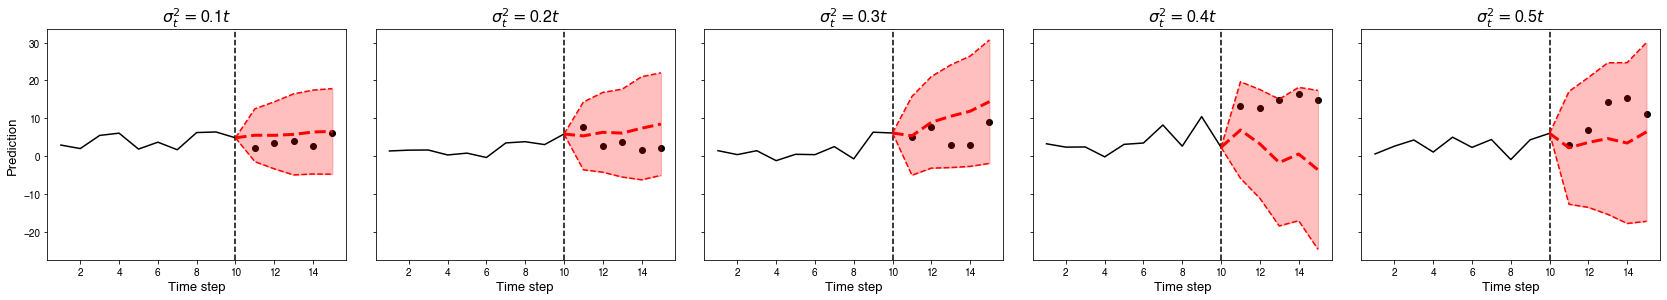

In [35]:
plot_timeseries(noise_mode='time-dependent', baseline='CPRNN', figure_name='time-dependent')

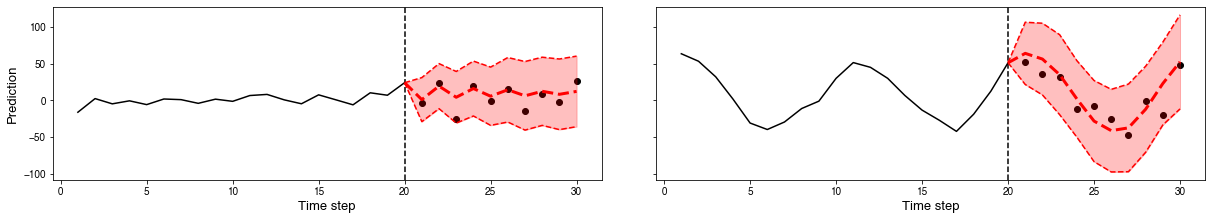

In [36]:
plot_timeseries(noise_mode='periodic', baseline='CPRNN', figsize=(20,3), figure_name='periodic')

## Long horizon analysis (Figure 4)

Training code for the three underlying RNN models:

```python
train_conformal_forecaster(noise_mode='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='GRU')
train_conformal_forecaster(noise_mode='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='RNN')
train_conformal_forecaster(noise_mode='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='LSTM')
```

Analyzing interval widths:

In [75]:
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/long-horizon_CPRNN_{}_100.pt'.format(rnn_model))
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [118]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

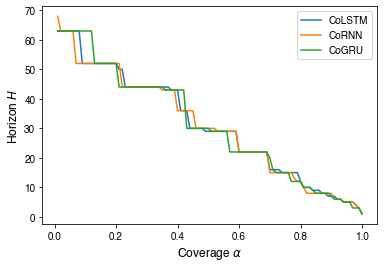

In [132]:
for threshold_width in [16]:
    valid_horizons = compute_valid_horizons(threshold_width)
    for rnn_model in valid_horizons.keys():
        plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.savefig('{}.png'.format('tradeoff') , bbox_inches='tight', dpi=1000)
plt.show()

## BJRNN baseline

Example for training the time-dependent noise profile, for a single seed.

In [ ]:
from utils.train_synthetic import train_bjrnn
results = train_bjrnn(noise_mode='time-dependent')